In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import lib, gto, scf
import pyqmc.recipes
import h5py
import matplotlib.pyplot as plt

This function computes the mean-field solution and saves the results to the file specified. We recommend using the ccecp pseudopotentials for high accuracy and efficiency.

In [2]:
def mean_field(chkfile):
    mol = gto.M(atom = "O 0 0 0; H 0 -2.757 2.587; H 0 2.757 2.587", basis='ccecpccpvdz', ecp='ccecp', unit='bohr')

    mf = scf.RHF(mol)
    mf.chkfile = chkfile
    mf.kernel()
mean_field("h2o.hdf5")

converged SCF energy = -16.4791748386414


Now we wish to construct a Slater-Jastrow wave function and optimize its energy. This is done using the OPTIMIZE function in pyqmc.recipes. It's often helpful to do the first optimization with only a few configurations, to get close to the minimum cheaply.

In [3]:
pyqmc.recipes.OPTIMIZE("h2o.hdf5","h2o_sj_200.hdf5",nconfig=200, **{'max_iterations':10,'verbose':True})

starting warmup
----------vmc done
----------vmc done
descent en -16.532595999921462 0.015659991091907067  estimated sigma  2.214657178881683
descent |grad| 0.5907823808338107
----------vmc done
descent en -16.653473090624807 0.01435742496004537  estimated sigma  2.0304465099250155
descent |grad| 0.20916175709690996
----------vmc done
descent en -16.688043222213373 0.0060682186518350835  estimated sigma  0.8581757116870555
descent |grad| 0.130127973476236
----------vmc done
descent en -16.698683264530832 0.0071050852153784075  estimated sigma  1.0048107873404708
descent |grad| 0.12201915789570904
----------vmc done
descent en -16.707333199917485 0.007824279095460601  estimated sigma  1.1065201612592674
descent |grad| 0.11722119916360173
----------vmc done
descent en -16.73443612123028 0.004899794377448467  estimated sigma  0.6929355661427059
descent |grad| 0.08204194140771276
----------vmc done
descent en -16.7472510509965 0.008302004132964334  estimated sigma  1.174080683971565
descen

* Since we want to start from the previous optimization, we use the `start_from` command in OPTIMIZE.

* Using `**kwargs` to pass a keyword to the line minimization algorithm so it only runs for 10 iterations, just to keep the computation low for this example.

In [5]:
pyqmc.recipes.OPTIMIZE("h2o.hdf5","h2o_sj_800.hdf5", start_from="h2o_sj_200.hdf5", nconfig=800, **{'max_iterations':10,'verbose':True})

starting warmup
----------vmc done
----------vmc done
descent en -16.746193462064095 0.005465997549694278  estimated sigma  1.5460175733351509
descent |grad| 0.08859462374885914
----------vmc done
descent en -16.75083869394403 0.0037228895387968787  estimated sigma  1.0529921753966927
descent |grad| 0.05740257128246137
----------vmc done
descent en -16.743789426644042 0.004742276960191476  estimated sigma  1.341318478726448
descent |grad| 0.09296604309468863
----------vmc done
descent en -16.750519380382265 0.006075085015976131  estimated sigma  1.7182935244326032
descent |grad| 0.052552467018306695
----------vmc done
descent en -16.750785786018387 0.0032394219613844696  estimated sigma  0.916246894407834
descent |grad| 0.0556494390129442
----------vmc done
descent en -16.75155931950424 0.0042569934268868355  estimated sigma  1.2040595678472965
descent |grad| 0.05025906505505981
----------vmc done
descent en -16.758000492626003 0.004213493904129673  estimated sigma  1.191756044839309
d

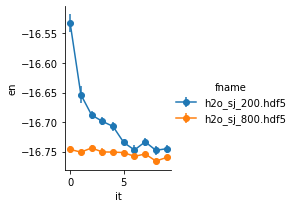

In [13]:
import seaborn as sns
df = pd.concat([pyqmc.recipes.read_opt(f"h2o_sj_{n}.hdf5") for n in [200,800]])
g = sns.FacetGrid(hue='fname',data=df)
g.map(plt.errorbar,'iteration','energy','error', marker='o')
g.add_legend()

In [7]:
for n in [200,800]:
    pyqmc.recipes.VMC("h2o.hdf5",f"h2o_sj_vmc_{n}.hdf5", start_from=f"h2o_sj_{n}.hdf5", **dict(nblocks=100,verbose=True))

----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done


                 fname  energyecp  energyecp_err   energyee  energyee_err  \
0  h2o_sj_vmc_200.hdf5   1.168404       0.006498  14.113493      0.009722   
1  h2o_sj_vmc_800.hdf5   1.174510       0.008018  14.062377      0.009882   

    energyei  energyei_err   energyke  energyke_err  energytotal  \
0 -47.625193      0.025821  12.240208      0.018623   -16.747708   
1 -47.548934      0.017921  12.198941      0.013006   -16.757726   

   energytotal_err  nconfig  
0         0.001643      200  
1         0.001557      800  


Text(0, 0.5, 'energy (Ha)')

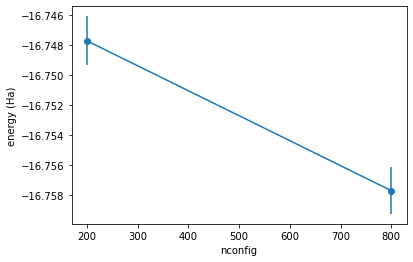

In [8]:
df = pd.DataFrame([pyqmc.recipes.read_mc_output(f"h2o_sj_vmc_{n}.hdf5") for n in [200,800]])
df['nconfig'] = [int(x.split('_')[3].replace('.hdf5','')) for x in df['fname']]
print(df)
plt.errorbar("nconfig","energytotal","energytotal_err", data=df, marker='o')
plt.xlabel("nconfig")
plt.ylabel("energy (Ha)")

In [14]:
pyqmc.recipes.DMC("h2o.hdf5",f"h2o_sj_dmc_800.hdf5", start_from=f"h2o_sj_800.hdf5",**{'verbose':True})


----------vmc done
eref start -16.758375637770172 esigma 1.2768006182077736
energy -16.769143715471888 eref -16.758375637770172 sigma(w) 0.02612398785780353
energy -16.79027222913535 eref -16.767387863489994 sigma(w) 0.023565371078780314
energy -16.795454282430402 eref -16.788132192893343 sigma(w) 0.02406865268428426
energy -16.798733288434498 eref -16.79244043540105 sigma(w) 0.025202935654142777
energy -16.790205251945032 eref -16.79474672514368 sigma(w) 0.02511106885762494
energy -16.778105883161217 eref -16.784684618015937 sigma(w) 0.024486942781102312
energy -16.792896046233945 eref -16.770785122605062 sigma(w) 0.023157424001147904
energy -16.787204885475937 eref -16.784468425232248 sigma(w) 0.023867112486189175
energy -16.78873034238901 eref -16.776956652491684 sigma(w) 0.024102809360063454
energy -16.758484475849702 eref -16.77736264369956 sigma(w) 0.03148688694446166
energy -16.79900568357653 eref -16.74526278361382 sigma(w) 0.025541872083207826
energy -16.81009718208616 eref -1

<ErrorbarContainer object of 3 artists>

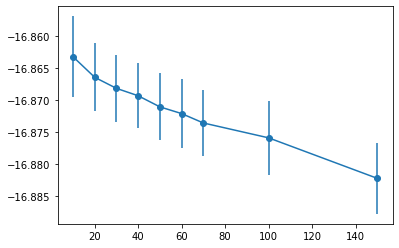

In [7]:
with h5py.File("h2o_sj_dmc_800.hdf5") as f:
    en = f['energytotal'][...]


df = pd.DataFrame([pyqmc.recipes.read_mc_output("h2o_sj_dmc_800.hdf5", warmup=warmup) for warmup in [10,20,30,40,50, 60,70, 100, 150]])
plt.errorbar("warmup",'energytotal', 'energytotal_err',data=df, marker='o')